# 💾 UCI Adult Dataset - Machine Learning Project


## Introduction

This machine learning project, conducted under the guidance of Professor Matteo Zignani from Università degli Studi di Milano, focuses on a supervised binary classification task using the Adult dataset. The dataset, originally from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/2/adult) is typically provided pre-split into training and test sets. To simulate and have greater control over the data splitting process, I used a [version of the dataset available on Kaggle](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset), which provides the data in a single, unsplit format. This approach allowed me to perform my own train-test split.

The goal of the project is to classify whether an individual earns more than $50,000 per year by leveraging preprocessing techniques and classification models to uncover patterns and relationships within the data, ultimately building an accurate predictive model.

#### Imports

In [1]:
# Base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, MinMaxScaler, StandardScaler, LabelBinarizer
from sklearn.compose import ColumnTransformer


# Model selection
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.pipeline import Pipeline as IMBPipeline
from imblearn.over_sampling import RandomOverSampler
from scipy.stats import uniform

# Custom utils
from utils.constants import country_mapping
from utils.configs import sampler_configs, dim_reduction_configs, classifier_configs
from utils.plots import plot_roc_auc, plot_precision_recall, plot_learning_curve, plot_validation_curve

## Analyze the data

Let's load the dataset into a Pandas dataframe and look more into detail the different columns we have.

In [2]:
df = pd.read_csv("../data/adult.csv", header=0, skipinitialspace=True, na_values="?")
df.shape # (rows, columns)

(48842, 15)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        46043 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       46033 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   47985 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


We can see that some columns have null values, let's look into more detail which ones and how many.

In [4]:
df.isnull().sum()

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

We will need to deal with missing values for the columns `workclass`, `occupation` and `native-country`.


In [5]:
# Look at some sample rows
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


Let's use the method `value_counts` to analyze each feature with more detail.

In [6]:
# Change 'race' for any other feature you'd like to inspect.
print(df['race'].value_counts())

race
White                 41762
Black                  4685
Asian-Pac-Islander     1519
Amer-Indian-Eskimo      470
Other                   406
Name: count, dtype: int64


## Definition of the Data Transformation Pipeline

Here we have a schema of the data transformation pipeline that we want to create. The columns that are not present are going to be dropped.

![Data transformatino Pipeline](./images/data-transformation-pipeline.jpg)

In this project, we utilize four custom transformers to handle specific feature engineering tasks. These transformers ensure that our preprocessing pipeline remains clean, modular, reusable and custom for each feature.

Below is an explanation of each custom transformer and their purpose along with the feature pipeline for it.

### Custom Transformers in the Project

#### 1. `MaritalStatusBinarizer`

Converts the **marital-status** feature into a binary feature (1 for married, 0 for not married) to simplify analysis and modeling.

In [7]:
def binarize_marital_status(X):
    mapping = {
        'Married-civ-spouse': 1,
        'Married-spouse-absent': 1,
        'Married-AF-spouse': 1,
        'Never-married': 0,
        'Divorced': 0,
        'Separated': 0,
        'Widowed': 0
    }

    X = X.values.ravel()

    return np.array([[mapping.get(value, 0)] for value in X])

# Pipeline for Marital Status
pipeline_marital_status = Pipeline([
    ('marital-status-binarizer', FunctionTransformer(binarize_marital_status,
    validate=False,
))
])


#### 2. `CombineCapitalFeatures`

Combines the **capital-gain** and **capital-loss** features into a single **net-capital** feature.

In [8]:
class CombineCapitalFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Convert X into a NumPy array
        X = np.asarray(X)
        
        # Compute net-capital (difference between gain and loss)
        net_capital = X[:, 0] - X[:, 1]
        
        # Return as a 2D array (Scikit-learn expects this format)
        return net_capital.reshape(-1, 1)

# Pipeline for combining and scaling capital features
pipeline_capital_features = Pipeline([
    ('combine_capital', CombineCapitalFeatures()),
    ('scaler', StandardScaler()), # I plotted this feature and it follows approximately a normal distribution so StandardScaler makes sense.
])

#### 3. `HoursBinner`

Bins the **hours-per-week** feature into categories: Part-time, Full-time, and Overtime.

In [9]:
class HoursBinner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.Series(X.values.ravel())
        
        # Define bins and labels
        bins = [0, 30, 50, float('inf')]  # Inf handles any hours > 50
        labels = ['Part-time', 'Full-time', 'Overtime']
        
        # Apply binning
        binned = pd.cut(X, bins=bins, labels=labels, right=False)
        
        # Return as a 2D array
        return np.array(binned).reshape(-1, 1)

# Pipeline for Hours Binning
pipeline_hours_binner = Pipeline([
    ('binning', HoursBinner()),
    ('onehot', OneHotEncoder())
])


#### 4. `CountryGrouper`

Groups the **native-country** feature into broader regions (e.g., North America, Europe) to reduce the number of categories and simplify the model.

In [10]:
class CountryGrouper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Flatten X to a 1D array for processing
        X_flat = np.ravel(X)

        # Apply mapping with a default value of "Other" for unknown countries
        grouped = [country_mapping.get(country, 'Other') for country in X_flat]

        # Return as a 2D array
        return np.array(grouped).reshape(-1, 1)

# Pipeline for Country Grouping and Encoding
pipeline_country = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('group', CountryGrouper()),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

### Column Transformer

We finish by creating the pipelines for the remaining features that have more than one transformation and defining the Column Transformer for **all** the features.

In [11]:
# Pipelines for the remaning features
pipeline_workclass_occupation = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine all pipelines in a ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('scaler', MinMaxScaler(), ['age', 'educational-num']),
    ('workclass_occupation', pipeline_workclass_occupation, ['workclass', 'occupation']),
    ('marital_status', pipeline_marital_status, ['marital-status']),
    ('relationship_and_race', OneHotEncoder(handle_unknown='ignore'), ['relationship', 'race']),
    ('gender', OneHotEncoder(drop="if_binary"), ['gender']),
    ('capital', pipeline_capital_features, ['capital-gain', 'capital-loss']),
    ('hours_per_week', pipeline_hours_binner, ['hours-per-week']),
    ('native_country', pipeline_country, ['native-country']),
],
remainder='drop',
verbose_feature_names_out=False,
sparse_threshold=0) # Dense matrices instead of sparse

## Training and test split

Now, we can split the entire dataset into training and test sets, putting 20% of the instances in the test set. I will then binarize the income column into 0/1 values for clarity and compatibility.

In [12]:
X = df.drop(columns=['income'])
y = df['income']

X_train, X_test, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

lb = LabelBinarizer()
# Because of lexicographical order, we will have 0 for <=50K and 1 for >50K
y_train = lb.fit_transform(y_train_orig).ravel()
y_test = lb.fit_transform(y_test_orig).ravel()

## Model example with KNN

Before delving into cross-validation, this section provides an illustrative example of how a single machine learning model can be trained, tested, and evaluated using the K-Nearest Neighbors (KNN) algorithm.

The following steps outline the process performed in the subsequent code cell:
1. **Apply Fitting and Transformation**: Preprocess the input features `X` by applying necessary transformations to prepare the data for model training.

2. **Create and Fit the Model**: Instantiate a KNN model and train it on the transformed training data. During this step, the hyperparameter `n_neighbors` can be tuned to observe its impact on performance later.

3. **Make Predictions**: Use the trained model to predict the target variable for both the training and test datasets.

4. **Evaluate Performance**: Measure the model's accuracy and F1 score to assess its performance on both the training and test sets.

5. **Analyze Performance**: Delve deeper into the model's performance by visualizing results using metrics like the confusion matrix, learning curve, ROC curve, and AUC score.

/Users/theo/Desktop/theo/Uni/Second Year/First Semester/Machine learning/ml-project/venv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/theo/Desktop/theo/Uni/Second Year/First Semester/Machine learning/ml-project/venv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/theo/Desktop/theo/Uni/Second Year/First Semester/Machine learning/ml-project/venv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  ret

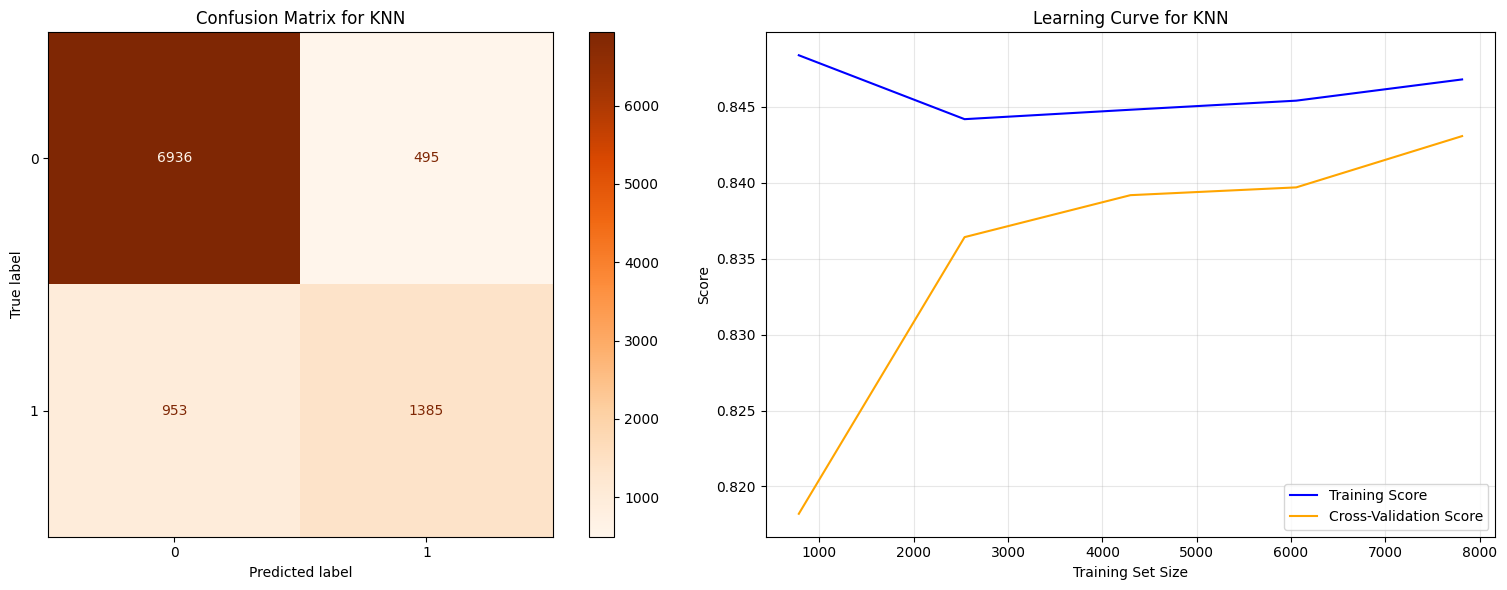

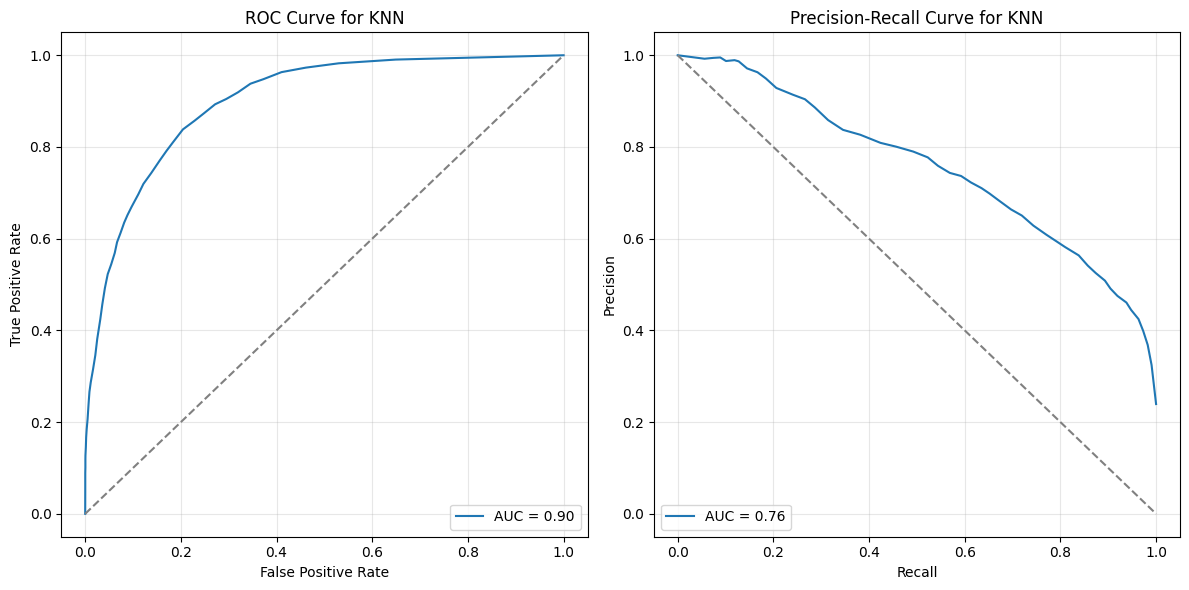

In [13]:
# 1) Preprocessing
X_train_knn = preprocessor.fit_transform(X_train)
X_test_knn = preprocessor.transform(X_test)

# 2) Create and fit the K-Nearest Neighbors model
model_knn = KNeighborsClassifier(n_neighbors=45)  # You can adjust `n_neighbors` to optimize performance
model_knn.fit(X_train_knn, y_train)

# 3) Make predictions on the training and test set
y_train_pred_knn = model_knn.predict(X_train_knn)
y_test_pred_knn = model_knn.predict(X_test_knn)

# 4) Evaluate the performance on training and test data
train_accuracy_knn = accuracy_score(y_train, y_train_pred_knn)
train_f1_knn = f1_score(y_train, y_train_pred_knn)

test_accuracy_knn = accuracy_score(y_test, y_test_pred_knn)
test_f1_knn = f1_score(y_test, y_test_pred_knn)

# 5) Analyze Performance
# Assuming you have y_test and y_prob already
y_prob = model_knn.predict_proba(X_test_knn)[:, 1]  # Predicted probabilities for class 1 (This changes the threshold of prediction)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot Confusion Matrix on the left
ConfusionMatrixDisplay.from_estimator(model_knn, X_test_knn, y_test, cmap=plt.cm.Oranges, ax=axes[0])
axes[0].set_title("Confusion Matrix for KNN")

# Plot Learning Curve on the right
plot_learning_curve(model_knn, X_test_knn, y_test, ax=axes[1], title="Learning Curve for KNN")

# Adjust layout and show
plt.tight_layout()
plt.show()

# Create a figure with subplots for inline plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot ROC Curve on the first axis
plt.sca(axes[0])  # Set current axis for the ROC plot
plot_roc_auc(y_test, y_prob, title="ROC Curve for KNN")

# Plot Precision-Recall Curve on the second axis
plt.sca(axes[1])  # Set current axis for the Precision-Recall plot
plot_precision_recall(y_test, y_prob, title="Precision-Recall Curve for KNN")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Model Selection with Nested Cross-Validation


This section focuses on selecting the best model and hyperparameters using **nested cross-validation**. By combining an *inner loop* for hyperparameter optimization and an *outer loop* for performance evaluation, this approach ensures a fair assessment of the model's generalization ability.

### Define possible configurations

We define the base pipeline by using the KNN example model created before and its configurations. We are using `IMBPipeline` because it extends the scikit-learn pipeline with the ability to incorporate samplers for balancing classes.

In [14]:
# Define the base pipeline
model_pipeline = IMBPipeline([  #IMB(alanced) pipeline allow us to add sampler configs
    ('preprocessing', preprocessor),
    ('sampler', None),
    ('dim_reduction', None),
    ('classifier', model_knn)
])

I defined the possible configurations in a separate file `configs.py` under utils for clarity, in this code cell we use itertools to form all the possible combinations of the different configurations defined before.

In [15]:
# Combine all possible configurations
all_configs = [
    dict(itertools.chain(*(config.items() for config in combination)))  # Unpack all configurations into a single dictionary
    for combination in itertools.product(sampler_configs, dim_reduction_configs, classifier_configs) # Cartesian product of all configurations
]

print(f"Number of configurations: {len(all_configs)}")

Number of configurations: 36


### Execute the nested cross validation

The `cross_validate` function from scikit-learn performs the outer cross-validation by splitting the dataset into 5 folds. For each fold, it passes the training data for that outer fold to RandomizedSearchCV.

RandomizedSearchCV then performs its inner 2-fold cross-validation on the training data from the outer fold, testing different hyperparameter combinations and selecting the best ones for that specific outer fold.

Finally, the model with the best hyperparameters (determined by the inner loop) is evaluated on the test data for the current outer fold, and the results are stored.

In [16]:

# Inner loop definition: RandomizedSearchCV with cv=2 which means 2-fold cross-validation
rs = RandomizedSearchCV(
    model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 5,
    random_state=42,
    n_jobs=-1, # Use all available CPU cores
    cv=2,
    scoring='f1',
)

In [17]:
# Outer loop with cross-validation (~35mins)
scores = cross_validate(
    rs,
    X_train,
    y_train,
    scoring='f1',
    cv=5,
    return_estimator=True,
    verbose=3,
)

/Users/theo/Desktop/theo/Uni/Second Year/First Semester/Machine learning/ml-project/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/theo/Desktop/theo/Uni/Second Year/First Semester/Machine learning/ml-project/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/theo/Desktop/theo/Uni/Second Year/First Semester/Machine learning/ml-project/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = colu

KeyboardInterrupt: 

We print the result for each fold:

In [ ]:
for index, estimator in enumerate(scores['estimator']):
    print('Classifier used: ', estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print('Sampler used: ', estimator.best_estimator_.get_params()['sampler'])
    print('Dimensionality reduction used: ', estimator.best_estimator_.get_params()['dim_reduction'])
    print('Score obtained: ', scores['test_score'][index])
    print('-'*50)

Classifier used:  GradientBoostingClassifier(max_depth=5, n_estimators=300) {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Sampler used:  RandomOverSampler(sampling_strategy=0.5)
Dimensionality reduction used:  None
Score obtained:  0.7328284147296944
--------------------------------------------------
Classifier used:  GradientBoostingClassifier(max_depth=5, n_estimators=300) {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_sam

To further reduce the number of candidates, we re-train them models on the entire training set and evaluate their performance on the test set to select our best candidate

In [ ]:
for estimator in scores['estimator']:
    best_model = estimator.best_estimator_.fit(X_train, y_train)
    
    # Make predictions on training and test sets
    pred_train = best_model.predict(X_train)
    pred_test = best_model.predict(X_test)
    
    # Compute F1 scores
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    
    # Print results
    print(f'F1 on training set: {f1_train:.3f}, F1 on test set: {f1_test:.3f}')

F1 on training set: 0.761, F1 on test set: 0.729
F1 on training set: 0.753, F1 on test set: 0.716
F1 on training set: 0.760, F1 on test set: 0.727
F1 on training set: 0.752, F1 on test set: 0.729
F1 on training set: 0.762, F1 on test set: 0.724


### Refinement of the selected model


From the previous step, we have identified one of the best candidate models. In this final step, we refine the hyperparameter optimization by keeping the modeling approach fixed and varying the hyperparameters within a range close to those of the selected model.

In [ ]:
# Define the pipeline with the best model configuration
best_model_pipeline = IMBPipeline([
    ('preprocessor', preprocessor),
    ('sampler', RandomOverSampler(sampling_strategy=0.5)),  # Include the sampler used in the best model.
    ('classifier', GradientBoostingClassifier()) # Of course the same classifier as well.
    # Dimentionality reduction is None on the best estimator, thus we skip it.
])

params = {
    'classifier__n_estimators': [100, 200, 300],  # Number of trees in the ensemble
    'classifier__max_depth': [3, 5],  # Maximum depth of each tree
}

# Perform RandomizedSearchCV
rs_best = RandomizedSearchCV(
    estimator=best_model_pipeline,
    param_distributions=params,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=1),
    n_iter=5,  # Number of random samples
    scoring='f1',
    n_jobs=-1,
)

# Fit the model
rs_best.fit(X_train, y_train)

# Compute metrics
# Evaluate on the test set
y_test_pred = rs_best.best_estimator_.predict(X_test)
final_f1 = f1_score(y_test, y_test_pred)
final_precision = precision_score(y_test, y_test_pred)
final_accuracy = accuracy_score(y_test, y_test_pred)

# Print results
print(f"Final Accuracy on Test Set: {final_accuracy:.3f}")
print(f"Final Precision on Test Set: {final_precision:.3f}")
print(f"Final F1 Score on Test Set: {final_f1:.3f}")

# Display the best parameters
print("Best Hyperparameters:", rs_best.best_params_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END classifier__max_depth=5, classifier__n_estimators=100; total time=  17.3s
[CV] END classifier__max_depth=5, classifier__n_estimators=100; total time=  17.5s
[CV] END classifier__max_depth=5, classifier__n_estimators=100; total time=  17.6s
[CV] END classifier__max_depth=3, classifier__n_estimators=200; total time=  22.6s
[CV] END classifier__max_depth=3, classifier__n_estimators=200; total time=  22.9s
[CV] END classifier__max_depth=3, classifier__n_estimators=200; total time=  22.9s
[CV] END classifier__max_depth=3, classifier__n_estimators=200; total time=  23.0s
[CV] END classifier__max_depth=3, classifier__n_estimators=200; total time=  23.1s
[CV] END classifier__max_depth=5, classifier__n_estimators=100; total time=  16.5s
[CV] END classifier__max_depth=5, classifier__n_estimators=100; total time=  17.4s
[CV] END classifier__max_depth=3, classifier__n_estimators=300; total time=  36.7s
[CV] END classifier__max_de

We have found the best model out of our configurations after cross validation and hyperparameter tunning: `Gradient Boosting Classifier` model.

### Learning and Validation curves

In this section, we will plot two functions to analyze the performance of the Gradient Boosting model. First, we will plot the learning curve to observe how varying the size of the training set impacts the model's performance on both the training and validation data. This will help us understand whether the model is underfitting, overfitting, or well-balanced. Next, we will plot the validation curve to examine how changing the number of trees (`n_estimators`) affects the model's performance, providing insights into the bias-variance trade-off and helping us determine an optimal range for this critical hyperparameter.

In [1]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

# Preprocessing
X_train_final = preprocessor.fit_transform(X_train)

# Define the model and cross-validator
model = GradientBoostingClassifier(n_estimators=200, max_depth=5)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

# Define the range for the validation curve
param_range = [100, 150, 200, 250]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the learning curve on the first axis
plot_learning_curve(
    estimator=model,
    X=X_train_final,
    y=y_train,
    ax=axes[0],
    title="Learning Curve for Gradient Boosting",
    cv=cv,
    scoring="f1"
)

# Plot the validation curve on the second axis
plot_validation_curve(
    estimator=model,
    X=X_train_final,
    y=y_train,
    param_name="n_estimators (trees)",
    param_range=param_range,
    cv=cv,
    scoring="f1",
    ax=axes[1],
    title="Validation Curve for Gradient Boosting (n_estimators)"
)

# Show the plots
plt.tight_layout()
plt.show()


NameError: name 'preprocessor' is not defined